In [27]:
import os
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [28]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
def get_file_absolute_path(directory):
    file_names = os.listdir(directory)
    file_absolute_path = []
    for file_name in file_names:
        file_absolute_path.append(directory + file_name)
    return file_absolute_path

def get_file_absolute_path(directory):
    file_names = os.listdir(directory)
    file_absolute_path = []
    for file_name in file_names:
        file_absolute_path.append(directory + file_name)
    return file_absolute_path

def convert_pandas_label_to_dict(dataframe):
    np_array = dataframe.values
    result = {}
    for indx, value in np_array:
        result[int(indx)] = value
    return result

def create_dataset_dataframe(directory, labels):
    data_container = {}
    paths = get_file_absolute_path(directory)
    for path in paths:
        data_container[path] = labels[int(re.findall('[0-9]+', path.split('/')[-1])[0])]
    return pd.DataFrame(list(data_container.items()), columns = ['file_absolute_path', 'label'])

In [30]:
dir_root = '/kaggle/input/bone-age-data-set-gray256clahe/Bone Age Datasets/'

training_root = 'Bone Age Training Set/'
validation_root = 'Bone Age Validation Set/'
test_root = 'Bone Age Test Set/'

data_path = 'Data/'
label_path = 'labels.csv'

training_dataset_path = dir_root + training_root + data_path
validation_dataset_path = dir_root + validation_root + data_path
test_dataset_path = dir_root + test_root + data_path

training_labels_path = dir_root + training_root + label_path
validation_labels_path = dir_root + validation_root + label_path
test_labels_path = dir_root + test_root + label_path

training_labels = pd.read_csv(training_labels_path).drop(columns=['male'])
validation_labels = pd.read_csv(validation_labels_path).drop(columns=['male'])
test_labels = pd.read_csv(test_labels_path).drop(columns=['Sex'])
 
training_labels = convert_pandas_label_to_dict(training_labels)
validation_labels = convert_pandas_label_to_dict(validation_labels)
test_labels = convert_pandas_label_to_dict(test_labels)

training_dataframe = create_dataset_dataframe(training_dataset_path, training_labels)
validation_dataframe = create_dataset_dataframe(validation_dataset_path, validation_labels)
test_dataframe = create_dataset_dataframe(test_dataset_path, test_labels)

In [31]:
SIZE = 256
batch_size = 32
CHANNELS = 1

def image_generator(file_names, labels):
    for file_name, label in zip(file_names, labels):
        image = tf.io.decode_png(tf.io.read_file(file_name), channels=CHANNELS)
        yield image, label

In [32]:
def train_data_augmentation(image, label):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    image = tf.cast(image, tf.float16) / 255.
    return image, label

def test_val_data_augmentation(image, label):
    image = tf.cast(image, tf.float16) / 255.
    return image, label

In [33]:
# def create_dataset(dataframe, shuffle, cache):
#     dataset = tf.data.Dataset.from_generator(image_generator,
#                                              args=[dataframe['file_absolute_path'].values, dataframe['label'].values],
#                                              output_signature=(tf.TensorSpec(shape=(SIZE, SIZE, CHANNELS), dtype=tf.float32),
#                                                                tf.TensorSpec(shape=(), dtype=tf.float32))).map(
#         normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache(cache)
#     if shuffle:
#         dataset = dataset.shuffle(buffer_size=len(dataframe))
#     return dataset.repeat().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# def create_dataset(dataframe, shuffle, cache):
#     dataset = tf.data.Dataset.from_tensor_slices(
#         (dataframe['file_absolute_path'].values, dataframe['label'].values)).map(convert_image_to_tensor,
#                                                                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).map(
#         normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache(cache)
#     if shuffle:
#         dataset = dataset.shuffle(buffer_size=len(dataframe))
#     return dataset.repeat().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


def create_dataset(dataframe, augmentation_func, shuffle):
    dataset = tf.data.Dataset.from_generator(
        image_generator,
        args=[dataframe['file_absolute_path'].values, dataframe['label'].values],
        output_signature=(tf.TensorSpec(shape=(None, None, None), dtype=tf.uint8), tf.TensorSpec(shape=(), dtype=tf.float16))
    )
    dataset = dataset.map(augmentation_func, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [34]:
train_dataset = create_dataset(training_dataframe, train_data_augmentation, True)
validation_dataset = create_dataset(validation_dataframe, test_val_data_augmentation, False)
test_dataset = create_dataset(test_dataframe, test_val_data_augmentation, False)

In [35]:
def plot_image(dataset, index):
    ds = dataset.take(1).get_single_element()
    plt.imshow(ds[0][index], cmap=plt.cm.gray, interpolation='nearest')
    plt.title("LABEL: %s" % ds[1][index].numpy())
    plt.show()
    print()
    return


def plot_history(history, metric, scale):
    print()
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.ylim([0,scale])
    name = metric.replace('_', ' ')
    plt.title('Model '+name.title())
    plt.ylabel(name.upper())
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='center right')
    plt.show()

In [36]:
# index = np.random.randint(0, batch_size, (1,))[0]

# print('A sample of test set: ')
# plot_image(test_dataset, index)

# print('A sample of validation set: ')
# plot_image(validation_dataset, index)

# print('A sample of train set: ')
# plot_image(train_dataset, index)

In [37]:
train_steps = int(np.ceil(len(training_dataframe) / batch_size))

val_steps = int(np.ceil(len(validation_dataframe) / batch_size))

test_steps = int(np.ceil(len(test_dataframe) / batch_size))

In [38]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor, threshold, max_epochs, patience=3):
        super(EarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.threshold = threshold
        self.best_weights = None
        self.max_epochs = max_epochs
        self.best_monitoring_value = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_monitoring_value = logs.get(self.monitor)
        if current_monitoring_value is None:
            raise ValueError(f"The metric {self.monitor} is not available in logs for early stopping.")
        if epoch>=self.max_epochs-1:
            print(f"\n--- Early stopping: Reached maximum number of epochs : {self.max_epochs} \n")
            self.model.stop_training = True
            self.model.set_weights(self.best_weights)
            return
        if current_monitoring_value < self.best_monitoring_value:
            self.best_weights = self.model.get_weights()
            self.best_monitoring_value = current_monitoring_value
        if current_monitoring_value > self.threshold:
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\n--- Early stopping: {self.monitor} has been below {self.threshold} for {self.patience} epochs.\n")
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)
                return

# First approach

In [51]:
class ShallowRegressor:
    def __init__(self, activation):
        self.activation = activation

    def __conv_pool(self, X, output_channels, conv_kernel, conv_strides, conv_padding, pool_size, pool_strides, pool_padding):
        X = tf.keras.layers.Conv2D(output_channels, conv_kernel, strides=conv_strides, padding=conv_padding, activation=None)(X)
        X = tf.keras.layers.BatchNormalization(axis=3)(X)
        X = tf.keras.layers.Activation(self.activation)(X)
        return tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    def __Shallow(self, input_shape, output_channels):
        X_input = tf.keras.Input(input_shape)

        X = self.__conv_pool(X_input, output_channels=output_channels, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same',
                             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='valid')

        X = self.__conv_pool(X, output_channels=2*output_channels, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same',
                             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='valid')

        X = self.__conv_pool(X, output_channels=4*output_channels, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same',
                             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='valid')

        X = self.__conv_pool(X, output_channels=8*output_channels, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same',
                             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='valid')

        return tf.keras.Model(inputs=X_input, outputs=X, name='Shallow-model')

    def create_model(self, input_shape):
        base_model = self.__Shallow(input_shape=input_shape,output_channels=32)
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dense(32, activation=self.activation)(fc)
        fc = tf.keras.layers.Dense(16, activation=self.activation, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(fc)
        fc = tf.keras.layers.Dropout(0.05)(fc)
        fc = tf.keras.layers.Dense(1, activation='linear')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='Shallow-Classifier')

shallow = ShallowRegressor('relu').create_model(input_shape=(SIZE, SIZE, CHANNELS))

In [52]:
number_of_epochs = 60
early_stopping = EarlyStopping(monitor='val_mean_absolute_error',
                               threshold=15,
                               max_epochs=number_of_epochs)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_densenet.h5',
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True,
    verbose=1)

In [53]:
shallow.summary()

Model: "Shallow-Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 batch_normalization_20 (Bat  (None, 256, 256, 16)     64        
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 128, 32

In [54]:
shallow.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                 metrics=[
                     tf.keras.metrics.MeanAbsoluteError(),
                     tf.keras.metrics.RootMeanSquaredError(),
                 ])

shallow_history = shallow.fit(train_dataset,
                                epochs=number_of_epochs,
                                steps_per_epoch=train_steps,
                                validation_data=validation_dataset,
                                validation_steps=val_steps,
                                callbacks=[checkpoint, early_stopping],
                                verbose='auto')

Epoch 1/60
395/395 [==============================] - ETA: 0s - loss: 0.3714 - mean_absolute_error: 35.6260 - root_mean_squared_error: 44.6314
Epoch 1: val_mean_absolute_error improved from inf to 38.24982, saving model to best_model_densenet.h5
395/395 [==============================] - 16s 32ms/step - loss: 0.3714 - mean_absolute_error: 35.6260 - root_mean_squared_error: 44.6314 - val_loss: 0.2504 - val_mean_absolute_error: 38.2498 - val_root_mean_squared_error: 45.0599
Epoch 2/60
395/395 [==============================] - ETA: 0s - loss: 0.1756 - mean_absolute_error: 29.2443 - root_mean_squared_error: 36.6132
Epoch 2: val_mean_absolute_error improved from 38.24982 to 29.82409, saving model to best_model_densenet.h5
395/395 [==============================] - 13s 32ms/step - loss: 0.1756 - mean_absolute_error: 29.2443 - root_mean_squared_error: 36.6132 - val_loss: 0.1974 - val_mean_absolute_error: 29.8241 - val_root_mean_squared_error: 37.4202
Epoch 3/60
395/395 [=====================

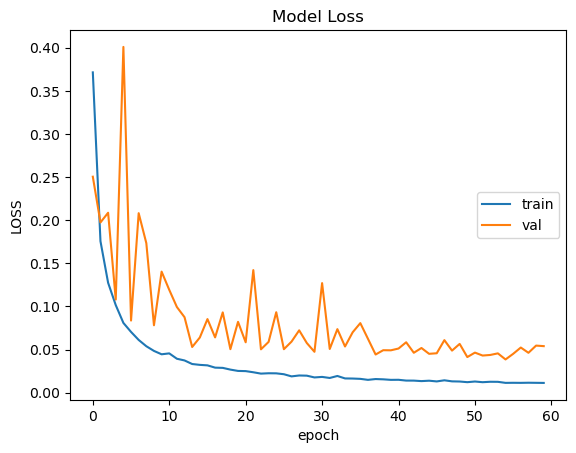

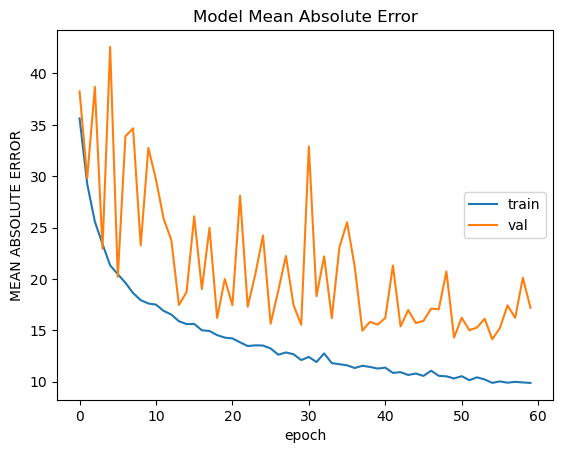

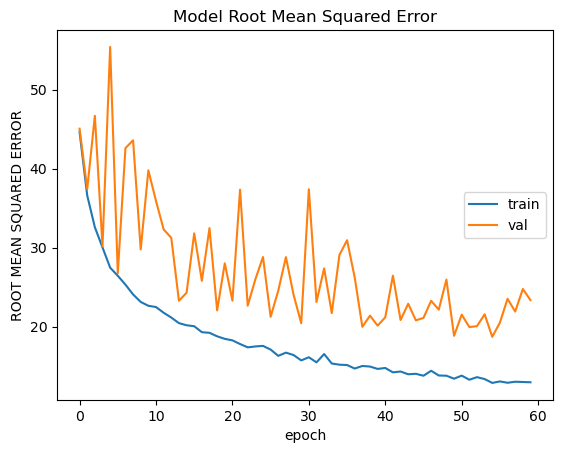

In [55]:
plot_history(shallow_history,'loss')
plot_history(shallow_history,'mean_absolute_error')
plot_history(shallow_history,'root_mean_squared_error')

In [56]:
shallow_score = shallow.evaluate(test_dataset, steps=test_steps, verbose='auto')
print("DenseNet regressor evaluation results:\n")
print('Testset Loss = {:.5f}'.format(shallow_score[0]))
print('Testset MAE = {:.2f}'.format(shallow_score[1]))
print('Testset RMSE = {:.2f}'.format(shallow_score[2]))

7/7 [==============================] - 0s 11ms/step - loss: 0.0526 - mean_absolute_error: 20.3696 - root_mean_squared_error: 26.5404
DenseNet regressor evaluation results:

Testset Loss = 0.05256
Testset MAE = 20.37
Testset RMSE = 26.54


# Secund approach

In [ ]:
class DenseNetRegressor:
    
    def __convblock(self, X, num_channels):
        X_shortcut = X
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.ReLU()(X)
        X = tf.keras.layers.Conv2D(filters=num_channels, kernel_size=(3, 3), padding='same')(X)
        return tf.keras.layers.concatenate([X_shortcut, X], axis=3)

    def __denseblock(self, X, num_convs, num_channels):
        for _ in range(num_convs):
            X = self.__convblock(X, num_channels)
        return X

    def __transitionblock(self, X, num_channels):
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.ReLU()(X)
        X = tf.keras.layers.Conv2D(filters=num_channels, kernel_size=(1, 1), padding='same')(X)
        return tf.keras.layers.AveragePooling2D(pool_size=2, strides=2)(X)

    def __DenseNet(self, input_shape, num_channels, growth_rate, arch):
        X_input = tf.keras.layers.Input(input_shape)
        X = tf.keras.layers.Conv2D(num_channels, kernel_size=7, strides=2, padding='same')(X_input)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.ReLU()(X)
        X = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(X)
        for i, num_convs in enumerate(arch):
            X = self.__denseblock(X, num_convs, growth_rate)
            num_channels += num_convs * growth_rate
            if i != len(arch) - 1:
                num_channels //= 2
                X = self.__transitionblock(X, num_channels)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.ReLU()(X)
        X = tf.keras.layers.GlobalAveragePooling2D()(X)
        return tf.keras.models.Model(inputs=X_input, outputs=X, name='DenseNet')

    def create_model(self, input_shape):
        base_model = self.__DenseNet(input_shape, num_channels=32, growth_rate=32, arch=(4, 4, 4, 4))
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dense(1, activation='linear', name='fc1')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='DenseNet_Regressor')
    
    
densenet = DenseNetRegressor().create_model(input_shape=(SIZE, SIZE, CHANNELS))

In [ ]:
densenet.summary()

In [ ]:
number_of_epochs = 75
early_stopping = EarlyStopping(monitor='val_mean_absolute_error',
                               threshold=14,
                               max_epochs=number_of_epochs)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_densenet.h5',
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True,
    verbose=1)

In [ ]:
densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                 metrics=[
                     tf.keras.metrics.MeanAbsoluteError(),
                     tf.keras.metrics.RootMeanSquaredError(),
                 ])

densenet_history = densenet.fit(train_dataset,
                                epochs=number_of_epochs,
                                steps_per_epoch=train_steps,
                                validation_data=validation_dataset,
                                validation_steps=val_steps,
                                callbacks=[checkpoint, early_stopping],
                                verbose='auto')

In [ ]:
plot_history(densenet_history,'loss')
plot_history(densenet_history,'mean_absolute_error')
plot_history(densenet_history,'root_mean_squared_error')

In [ ]:
densenet_score = densenet.evaluate(test_dataset, steps=test_steps, verbose='auto')
print("DenseNet regressor evaluation results:\n")
print('Testset Loss = {:.5f}'.format(densenet_score[0]))
print('Testset MAE = {:.2f}'.format(densenet_score[1]))
print('Testset RMSE = {:.2f}'.format(densenet_score[2]))

# Third approach

In [ ]:
class ResNet50Regressor:

    def __init__(self, activation):
        self.activation = activation


    def __identity_block(self, X, f, filters, stage, block):

        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        F1, F2, F3 = filters

        X_shortcut = X

        X = tf.keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
        X = tf.keras.layers.Activation(self.activation)(X)

        X = tf.keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
        X = tf.keras.layers.Activation(self.activation)(X)

        X = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

        X = tf.keras.layers.Add()([X, X_shortcut])

        return tf.keras.layers.Activation(self.activation)(X)


    def __convolutional_block(self, X, f, filters, stage, block, s=2):

        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'

        F1, F2, F3 = filters

        X_shortcut = X

        X = tf.keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
        X = tf.keras.layers.Activation(self.activation)(X)

        X = tf.keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
        X = tf.keras.layers.Activation(self.activation)(X)

        X = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

        X_shortcut = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1')(X_shortcut)
        X_shortcut = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

        X = tf.keras.layers.Add()([X, X_shortcut])

        return tf.keras.layers.Activation(self.activation)(X)


    def __ResNet50(self, input_shape):

        X_input = tf.keras.layers.Input(input_shape)
        X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)
        X = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name='bn_conv1')(X)
        X = tf.keras.layers.Activation(self.activation)(X)
        X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

        X = self.__convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
        X = self.__identity_block(X, 3, [64, 64, 256], stage=2, block='b')
        X = self.__identity_block(X, 3, [64, 64, 256], stage=2, block='c')


        X = self.__convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
        X = self.__identity_block(X, 3, [128, 128, 512], stage=3, block='b')
        X = self.__identity_block(X, 3, [128, 128, 512], stage=3, block='c')
        X = self.__identity_block(X, 3, [128, 128, 512], stage=3, block='d')

        X = self.__convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

        X = self.__convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
        X = self.__identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
        X = self.__identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
        X = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)

        return tf.keras.models.Model(inputs=X_input, outputs=X, name='ResNet50')


    def create_model(self, input_shape):
        base_model = self.__ResNet50(input_shape=input_shape)
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dense(256, activation=self.activation, name='fc1')(fc)
        fc = tf.keras.layers.Dense(128, activation=self.activation, name='fc2')(fc)
        fc = tf.keras.layers.Dense(64, activation=self.activation, name='fc3')(fc)
        fc = tf.keras.layers.Dense(32, activation=self.activation, name='fc4', kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(fc)
        fc = tf.keras.layers.Dropout(0.01)(fc)
        fc = tf.keras.layers.Dense(1, activation='linear', name='fc5')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='ResNet50_Regressor')


resnet50 = ResNet50Regressor(activation='relu').create_model(input_shape=(SIZE, SIZE, CHANNELS))

In [ ]:
resnet50.summary()

In [ ]:
number_of_epochs = 75
early_stopping = EarlyStopping(monitor='val_mean_absolute_error', threshold=12, max_epochs = number_of_epochs)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_resnet50.h5',
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True,
    verbose=1)

In [ ]:
resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                 metrics=[
                     tf.keras.metrics.MeanAbsoluteError(),
                     tf.keras.metrics.RootMeanSquaredError(),
                 ])

resnet50_history = resnet50.fit(train_dataset,
                                epochs=number_of_epochs,
                                steps_per_epoch=train_steps,
                                validation_data=validation_dataset,
                                validation_steps=val_steps,
                                callbacks=[checkpoint, early_stopping],
                                verbose='auto')


In [ ]:
plot_history(resnet50_history,'loss')
plot_history(resnet50_history,'mean_absolute_error')
plot_history(resnet50_history,'root_mean_squared_error')

In [ ]:
resnet50_score = resnet50.evaluate(test_dataset, steps=test_steps, verbose='auto')
print("ResNet50 regressor evaluation results:\n")
print('Testset Loss = {:.5f}'.format(resnet50_score[0]))
print('Testset MAE = {:.2f} %'.format(resnet50_score[1]))
print('Testset RMSE = {:.2f}'.format(resnet50_score[2]))

# Forth Approach
## Inception-V4 For Bone Age Prediction

In this approach, we implement the InceptionV4 from scratch for the regression task.



**We consider the following points:**

- All hidden layers use GELU as their activation function
- The final layer uses Linear as its activation function
- The Adam optimizer is used to minimize the gradient
- The Mean Squared Logarithmic Error is used for the loss function
- The RMSE, MAPE and, R Squared metrics are used to evaluate model performance

In [ ]:
class InceptionV4Regressor:

    def __init__(self, activation):
        self.activation = activation
        

    def __conv2d_with_batch(self, prev_layer, nbr_kernels, filter_size, strides=(1, 1), padding='valid'):
        X = tf.keras.layers.Conv2D(filters=nbr_kernels, kernel_size=filter_size, strides=strides, padding=padding)(prev_layer)
        X = tf.keras.layers.BatchNormalization()(X)
        return tf.keras.layers.Activation(activation=self.activation)(X)
    

    def __stem_block(self, prev_layer):
        X = self.__conv2d_with_batch(prev_layer, nbr_kernels=32, filter_size=(3, 3), strides=(2, 2))
        X = self.__conv2d_with_batch(X, nbr_kernels=32, filter_size=(3, 3))
        X = self.__conv2d_with_batch(X, nbr_kernels=64, filter_size=(3, 3))
        X_1 = self.__conv2d_with_batch(X, nbr_kernels=96, filter_size=(3, 3), strides=(2, 2))
        
        X_2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
        
        X = tf.keras.layers.concatenate([X_1, X_2], axis=3)
        
        X_1 = self.__conv2d_with_batch(X, nbr_kernels=64, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(X_1, nbr_kernels=64, filter_size=(1, 7), padding='same')
        X_1 = self.__conv2d_with_batch(X_1, nbr_kernels=64, filter_size=(7, 1), padding='same')
        X_1 = self.__conv2d_with_batch(X_1, nbr_kernels=96, filter_size=(3, 3))
        X_2 = self.__conv2d_with_batch(X, nbr_kernels=96, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(X_2, nbr_kernels=96, filter_size=(3, 3))
        
        X = tf.keras.layers.concatenate([X_1, X_2], axis=3)
        
        X_1 = self.__conv2d_with_batch(X, nbr_kernels=192, filter_size=(3, 3), strides=2)
        
        X_2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
        
        return tf.keras.layers.concatenate([X_1, X_2], axis=3)
    

    def __reduction_A_block(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=224, filter_size=(3, 3), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(3, 3), strides=(2, 2))
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(3, 3), strides=(2, 2))
        
        X_3 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(prev_layer)
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3], axis=3)
    

    def __reduction_B_block(self, prev_layer):
        X_1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(prev_layer)
        
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=192, filter_size=(3, 3), strides=(2, 2))
        X_3 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=256, filter_size=(1, 1))
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=256, filter_size=(1, 7), padding='same')
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=320, filter_size=(7, 1), padding='same')
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=320, filter_size=(3, 3), strides=(2, 2))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3], axis=3)
    

    def __inception_block_A(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=64, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=96, filter_size=(3, 3), strides=(1, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=96, filter_size=(3, 3), strides=(1, 1), padding='same')
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=64, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=96, filter_size=(3, 3), padding='same')
        
        X_3 = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
        
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=96, filter_size=(1, 1), padding='same')
        X_4 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=96, filter_size=(1, 1))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3, X_4], axis=3)

    def __inception_block_B(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=192, filter_size=(7, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=224, filter_size=(1, 7), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=224, filter_size=(7, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(1, 7), padding='same')
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=224, filter_size=(1, 7), padding='same')
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=256, filter_size=(7, 1), padding='same')
        
        X_3 = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
        
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=128, filter_size=(1, 1))
        X_4 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3, X_4], axis=3)

    def __inception_block_C(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=448, filter_size=(3, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=512, filter_size=(1, 3), padding='same')
        X_1_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(1, 3), padding='same')
        X_1_2 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(3, 1), padding='same')
        
        X_1 = tf.keras.layers.concatenate([X_1_1, X_1_2], axis=3)
        
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
        X_2_1 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=256, filter_size=(1, 3), padding='same')
        X_2_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=256, filter_size=(3, 1), padding='same')
        
        X_2 = tf.keras.layers.concatenate([X_2_1, X_2_2], axis=3)
        
        X_3 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
        
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=256, filter_size=3, padding='same')
        X_4 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=256, filter_size=(1, 1))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3, X_4], axis=3)
    

    def __InceptionV4(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=input_shape)
        
        X = self.__stem_block(prev_layer=input_layer)
        
        X = self.__inception_block_A(prev_layer=X)
        X = self.__inception_block_A(prev_layer=X)
        X = self.__inception_block_A(prev_layer=X)
        X = self.__inception_block_A(prev_layer=X)
        
        X = self.__reduction_A_block(prev_layer=X)
        
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        
        X = self.__reduction_B_block(prev_layer=X)
        
        X = self.__inception_block_C(prev_layer=X)
        X = self.__inception_block_C(prev_layer=X)
        X = self.__inception_block_C(prev_layer=X)
        
        output = tf.keras.layers.GlobalAveragePooling2D()(X)
        
        return tf.keras.models.Model(inputs=input_layer, outputs=output, name='InceptionV4')

    def create_model(self, input_shape):
        base_model = self.__InceptionV4(input_shape=input_shape)
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dropout(rate=0.05)(fc)
        fc = tf.keras.layers.Dense(1, activation='linear')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='InceptionV4_Regressor')
    
    
inceptionv4 = InceptionV4Regressor(activation='relu').create_model(input_shape=(SIZE, SIZE, CHANNELS))    

In [ ]:
number_of_epochs = 75
early_stopping = EarlyStopping(monitor='val_mean_absolute_error',
                               threshold=12,
                               max_epochs=number_of_epochs)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_inceptionv4.h5',
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True,
    verbose=1)

In [ ]:
inceptionv4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                    metrics=[
                        tf.keras.metrics.MeanAbsoluteError(),
                        tf.keras.metrics.RootMeanSquaredError(),
                    ])

inceptionv4_history = inceptionv4.fit(train_dataset,
                                      epochs=number_of_epochs,
                                      steps_per_epoch=train_steps,
                                      validation_data=validation_dataset,
                                      validation_steps=val_steps,
                                      callbacks=[checkpoint, early_stopping],
                                      verbose='auto')

In [ ]:
plot_history(inceptionv4_history,'loss')
plot_history(inceptionv4_history,'mean_absolute_error')
plot_history(inceptionv4_history,'root_mean_squared_error')

In [ ]:
inceptionv4_score = inceptionv4.evaluate(test_dataset, steps=test_steps, verbose='auto')
print("Inception V4  regressor evaluation results:\n")
print('Testset Loss = {:.5f}'.format(inceptionv4_score[0]))
print('Testset MAE = {:.2f} %'.format(inceptionv4_score[1]))
print('Testset RMSE = {:.2f}'.format(inceptionv4_score[2]))

## Conclusion

Both of the models showed a good result in the performance evaluation, but Inception-V4 results are slightly better than ResNet-50.

### Part Two: Transfer Learnin Phase

In this part we use transfer learning technique and load the trained model to perform a prediction task on the testset.

In [ ]:
import os
import re
import random
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
def get_file_name(dir):
    return os.listdir(dir)

def get_file_absolute_path(dir):
    file_names = os.listdir(dir)
    file_absolute_path = []
    for file_name in file_names:
        file_absolute_path.append(dir + file_name)
    return file_absolute_path

In [ ]:
dir_root = '/kaggle/input/human-data-dataset/Bone Age Dataset/Bone Age Dataset/'

training_root = 'Bone Age Training Set/'
validation_root = 'Bone Age Validation Set/'
test_root = 'Bone Age Test Set/'

data_path = 'data/'
label_path = 'labels/'

training_dataset_path = dir_root + training_root + data_path
validation_dataset_path = dir_root + validation_root + data_path
test_dataset_path = dir_root + test_root + data_path

training_labels_path = dir_root + training_root + label_path
validation_labels_path = dir_root + validation_root + label_path
test_labels_path = dir_root + test_root + label_path

In [ ]:
training_labels = pd.read_csv(training_labels_path + get_file_name(training_labels_path)[0]).drop(columns=['male'])
validation_labels = pd.read_csv(validation_labels_path + get_file_name(validation_labels_path)[0]).drop(columns=['male'])
test_labels = pd.read_csv(test_labels_path + get_file_name(test_labels_path)[0]).drop(columns=['Sex'])

def convert_pandas_label_to_dict(dataframe):
    np_array = dataframe.values
    result = {}
    for indx, value in np_array:
        result[int(indx)] = value
    return result

training_labels = convert_pandas_label_to_dict(training_labels)
validation_labels = convert_pandas_label_to_dict(validation_labels)
test_labels = convert_pandas_label_to_dict(test_labels)

In [ ]:
def create_dataset_datafram(dir, labels):
    data_container = {}
    paths = get_file_absolute_path(dir)
    for path in paths:
        data_container[path] = labels[int(re.findall('[0-9]+', path)[0])]
    return pd.DataFrame(list(data_container.items()), columns = ['file_absolute_path', 'label'])

training_dataframe = create_dataset_datafram(training_dataset_path, training_labels)
validation_dataframe = create_dataset_datafram(validation_dataset_path, validation_labels)
test_dataframe = create_dataset_datafram(test_dataset_path, test_labels)

In [ ]:
SIZE = 256
batch_size = 32

training_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255.)
val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_dataset = training_data_generator.flow_from_dataframe(
    dataframe=training_dataframe,
    directory=None,
    x_col="file_absolute_path",
    y_col="label",
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    classes=None,
    class_mode='raw')

validation_dataset = val_data_generator.flow_from_dataframe(
    dataframe=validation_dataframe,
    directory=None,
    x_col="file_absolute_path",
    y_col="label",
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    batch_size=batch_size,
    seed=None,
    shuffle=False,
    classes=None,
    class_mode='raw')

test_dataset = val_data_generator.flow_from_dataframe(
    dataframe=test_dataframe,
    directory=None,
    x_col="file_absolute_path",
    y_col="label",
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    batch_size=batch_size,
    seed=None,
    shuffle=False,
    classes=None,
    class_mode='raw')

In [ ]:
print('Batch size: ' + str(batch_size))
X_train_sample = train_dataset.__getitem__(0)[0]
y_train_sample = train_dataset.__getitem__(0)[1]
print ('X_train shape: '  + str(X_train_sample.shape))
print ('y_train shape: ' + str(y_train_sample.shape))
X_val_sample = validation_dataset.__getitem__(0)[0]
y_val_sample = validation_dataset.__getitem__(0)[1]
print ('X_val shape: '  + str(X_val_sample.shape))
print ('y_val shape: ' + str(y_val_sample.shape))
index = random.randint(0, 5)
X_test_sample = test_dataset.__getitem__(index)[0]
y_test_sample = test_dataset.__getitem__(index)[1]
print ('X_test shape: '  + str(X_test_sample.shape))
print ('y_test shape: ' + str(y_test_sample.shape))
print("\n")

def plot_image(X_input, labels):
    plt.imshow(X_input, cmap=plt.cm.gray_r, interpolation='nearest')
    print("LABEL: %s" % labels)
    plt.show()
    return

for i in range(3):
    plot_image(X_test_sample[i], y_test_sample[i])
    print("\n")

In [ ]:
def load_pretrained_model(model_name):
    name_builder = '/kaggle/input/human-data-dataset/' + model_name
    prepared_model = tf.keras.models.load_model(name_builder + 'regressor.h5', custom_objects={'r_squared': r_squared})
    history = np.load(name_builder + 'history.npy', allow_pickle=True).item()
    return prepared_model, history

In [ ]:
def r_squared(y_true, y_pred):
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    return 1. - tf.divide(unexplained_error, total_error)

In [ ]:
resnet50_model, resnet50_history = load_pretrained_model('resnet50')

In [ ]:
inceptionv4_model, inceptionv4_history = load_pretrained_model('inceptionv4')

In [ ]:
test_steps = int(np.ceil(test_dataset.n / batch_size))

In [ ]:
resnet50_predictions = resnet50_model.predict(test_dataset, steps=test_steps)

In [ ]:
inceptionv4_predictions = inceptionv4_model.predict(test_dataset, steps=test_steps)

In [ ]:
def mean_of_errors(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def get_test_labels(dataset):
    number_of_generator_calls = math.ceil(dataset.n / (1.0 * batch_size))
    dataset_labels = []
    for i in range(0, int(number_of_generator_calls)):
        dataset_labels.extend(np.array(dataset[i][1]))
    return np.array(dataset_labels, dtype='float32').reshape(200, 1)

In [ ]:
resne50_mean_errors = mean_of_errors(get_test_labels(test_dataset), resnet50_predictions)
print('The mean of difference between true labels and predicted labels for testset for ResNet-50 is: {:.2f}'.format(resne50_mean_errors))

inceptionv4_mean_errors = mean_of_errors(get_test_labels(test_dataset), inceptionv4_predictions)
print('The mean of difference between true labels and predicted labels for testset for InceptionV4 is: {:.2f}'.format(inceptionv4_mean_errors))

We can say that the mean error of ResNet-50 for Testset is **13.92 month**.

We can say that the mean error of InceptionV4 for Testset is **11.32 month**.